# Noises

## Perlin Noise

Perlin noise steps:
* Define a grid of vectors at regular intervals. The interval/pixel ratio will determine the frequency of the noise.
* For each point on the grid, the vector can either be `[1, 1]`, `[-1, 1]`, `[-1, -1]`, or `[1, -1]`. The choice of vector can be made using a hash function based on the grid coordinates. This way, the vectors won't have to be stored in memory.
* The noise value at any point is calculated by:
    * Determining the grid cell in which the point lies.
    * For each corner, calculating the dot product of the corner's gradient vector and the distance vector from the corner to the point.
    * Interpolating the dot products using a fade function: $f(t) = 6t^5 - 15t^4 + 10t^3$.
* The final noise value is the result of the interpolation.

In [18]:
import numpy as np

def pcg_hash(x: np.uint32) -> np.uint32:
    """
    The PCG hash, as recommended by Nathan Reed in "Hash Functions for GPU Rendering" (2021)
    https://www.reedbeta.com/blog/hash-functions-for-gpu-rendering/
    
    :param x: Unsigned integer input to the hash function  
    :return: The hashed value.
    """
    with np.errstate(over="ignore"):  # ignore overflow warnings since that's intentional to the hash algorithm
        state = x * np.uint32(747796405) + np.uint32(2891336453)
        word = ((state >> ((state >> np.uint32(28)) + np.uint32(4))) ^ state) * np.uint32(277803737)
        return (word >> np.uint32(22)) ^ word


In [19]:
possible_vectors = np.array([
    [1, 1],
    [-1, 1],
    [-1, -1],
    [1, -1],
    [np.sqrt(2) / 2, np.sqrt(2) / 2],
    [-np.sqrt(2) / 2, np.sqrt(2) / 2],
    [-np.sqrt(2) / 2, -np.sqrt(2) / 2],
    [np.sqrt(2) / 2, -np.sqrt(2) / 2]
], dtype=np.float32)

def get_gradient_vector(x: int, y: int) -> np.ndarray:
    """
    Get the gradient vector for the grid point at (x, y) using the PCG hash function.
    
    :param x: The x-coordinate of the grid point.
    :param y: The y-coordinate of the grid point.
    :return: The gradient vector for the grid point.
    """
    # First combine the coordinates into a single integer. For a 2D plane made of positive integers, we can use the Cantor pairing function:
    #  pi(x, y) = (x + y)(x + y + 1)/2 + y
    # Since x or y can be negative, we first need to map negative integers into nonnegative integers using a bijection:
    # f(n) = 2n if n >= 0 else -2n - 1
    
    x_mapped = 2 * x if x >= 0 else -2 * x - 1
    y_mapped = 2 * y if y >= 0 else -2 * y - 1
    
    paired = (x_mapped + y_mapped) * (x_mapped + y_mapped + 1) // 2 + y_mapped
    hashed = pcg_hash(np.uint32(paired))
    
    return possible_vectors[hashed % len(possible_vectors)]

In [20]:
def fade(t: float) -> float:
    """
    The fade function used for interpolation in Perlin noise.
    
    :param t: The input value to the fade function, typically in the range [0, 1].
    :return: The output of the fade function.
    """
    return 6 * t**5 - 15 * t**4 + 10 * t**3

In [21]:
def perlin_noise(x: float, y: float) -> float:
    """
    Calculate the Perlin noise value at the point (x, y).
    :param x: The x-coordinate
    :param y: The y-coordinate
    :return: Perlin noise value at (x, y)
    """
    
    x0 = int(np.floor(x))
    x1 = x0 + 1
    y0 = int(np.floor(y))
    y1 = y0 + 1
    
    topleft_gradient = get_gradient_vector(x0, y0)
    topright_gradient = get_gradient_vector(x1, y0)
    bottomleft_gradient = get_gradient_vector(x0, y1)
    bottomright_gradient = get_gradient_vector(x1, y1)
    
    topleft_distance = np.array([x - x0, y - y0])
    topright_distance = np.array([x - x1, y - y0])
    bottomleft_distance = np.array([x - x0, y - y1])
    bottomright_distance = np.array([x - x1, y - y1])
    
    topleft_dot = np.dot(topleft_gradient, topleft_distance)
    topright_dot = np.dot(topright_gradient, topright_distance)
    bottomleft_dot = np.dot(bottomleft_gradient, bottomleft_distance)
    bottomright_dot = np.dot(bottomright_gradient, bottomright_distance)
    
    u = fade(x - x0)
    v = fade(y - y0)
    
    lerp_top = (1 - u) * topleft_dot + u * topright_dot
    lerp_bottom = (1 - u) * bottomleft_dot + u * bottomright_dot
    
    return (1 - v) * lerp_top + v * lerp_bottom

In [22]:
image_size = 256
noise_image = np.zeros((image_size, image_size), dtype=np.float32)
for i in range(image_size):
    for j in range(image_size):
        noise_image[i, j] = perlin_noise(i / 8, j / 8)

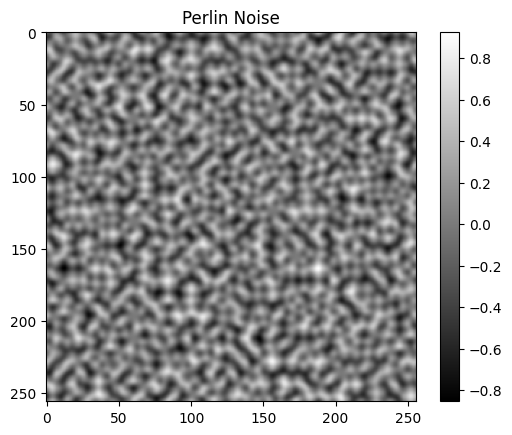

In [23]:
import matplotlib.pyplot as plt

plt.imshow(noise_image, cmap="gray")
plt.colorbar()
plt.title("Perlin Noise")
plt.show()

## Worley Noise